# Homework 3

**Name**: **[Arvin Hosseini]**

**UID**: **[205594617]**

Note: Please remember to make a copy of this colab notebook in your drive.

In [ ]:
# Download a processed version of the data
!wget https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt

--2022-12-06 00:29:35--  https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mushroom.txt.10’

mushroom.txt.10     100%[===================>]   1.21M  2.96MB/s    in 0.4s    

2022-12-06 00:29:36 (2.96 MB/s) - ‘mushroom.txt.10’ saved [1264848/1264848]



In [ ]:
# Use only the provided packages
import sys
import math
import csv
import pandas
import os
import random
import numpy as np
from collections import Counter
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

mpl.lines.width = 2
mpl.axes.labelsize = 14

In [ ]:
# Load the Mushroom dataset

@dataclass
class Dataset:
    """Class for the dataset."""
    X: np.array
    y: np.array
    Xnames: list
    yname: str

def load_data(data_file='mushroom.txt'):
    """Load data and map strings to numbers."""
    data = pandas.read_csv(data_file).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1
    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]
    #0 'cap-shape', 
    #1 'cap-surface', 
    #2 'cap-color', 
    #3 'bruises', 
    #4 'odor',      
    #5 'gill-attachment', 
    #6 'gill-spacing', 
    #7 'gill-size', 
    #8 'gill-color',
    #9 'stalk-shape', 
    #10 'stalk-root', 
    #11 'stalk-surface-above-ring', 
    #12 'stalk-surface-below-ring',
    #13 'stalk-color-above-ring',
    #14 'stalk-color-below-ring',
    #15 'veil-type',
    #16 'veil-color',
    #17 'ring-number',
    #18 'ring-type',
    #19 'spore-print-color',
    #20 'population',
    #21 'habitat',        
    Xnames = [
        'cap-shape', 
        'cap-surface', 
        'cap-color', 
        'bruises', 
        'odor',
        'gill-attachment', 
        'gill-spacing', 
        'gill-size', 
        'gill-color',
        'stalk-shape', 
        'stalk-root', 
        'stalk-surface-above-ring', 
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat',
    ]

    features=np.arange(1,22)
    features=list(features)
    
    X = np.take(X, features, axis=-1)
    Xnames = [Xnames[i] for i in features]
    return Dataset(X=X, y=y, Xnames=Xnames, yname='edible')

data = load_data()

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


# Shuffle the data for cross-validation
import random
idx = list(range(n))
random.seed(0)
random.shuffle(idx)
X = np.take(X, idx, axis=0)
y = np.take(y, idx, axis=0)

In [ ]:
import os.path
import numpy as np
import pickle
import sys
import pylab as plt
from sklearn import datasets
from sklearn.decomposition import PCA

def plot_2dclustering(X,y,d1,d2):
    plt.figure()
    plt.scatter(X[:,d1], X[:,d2], c=y)
    plt.title('Clustering Plot')
    

def plot_2dclustering_PCA(X,y):

    #Applying PCA (Xt is transformed data)
    pca = PCA()
    Xt = pca.fit_transform(X)

    plt.figure()
    plt.scatter(Xt[:,0], Xt[:,1], c=y)
    plt.title('PCA Plot')


def Purity(y, new_y):


    #create the two different clusters (in the form of arrays) based on the values of new_y 
    #first cluster is all y values that have a corresponding 0 cluster label
    cluster_0 = y[new_y == 0]
    #second cluster is the remaining y values that have a 1 cluster label
    cluster_1 = y[new_y == 1]

    #count the amount of 1s in cluster 0
    #check if its the majory by seeing if it is half of the total length
    #if it is more than half then set the majory count to all ys in the cluster with label 1
    #else set the count to the length of all elements of the cluster labeled 0
    c0_majority_count = 0
    if sum(cluster_0) > len(cluster_0)/2:
      c0_majority_count = len(cluster_0[cluster_0==1])
    else:
      c0_majority_count = len(cluster_0[cluster_0==0])

    #repeat for the second cluster
    c1_majority_count = 0
    if sum(cluster_1) > len(cluster_1)/2:
      c1_majority_count = len(cluster_1[cluster_1==1])
    else:
      c1_majority_count = len(cluster_1[cluster_1==0])
    
    #calculate the sum of the counts and divide by the total number of data points
    purity = (c0_majority_count + c1_majority_count) / len(y)


    return purity

def euclidean_dist_squared(X, Xtest):
    """Computes the Euclidean distance between rows of 'X' and rows of 'Xtest'
    Parameters
    ----------
    X : an N by D numpy array
    Xtest: an T by D numpy array
    Returns: an array of size N by T containing the pairwise squared Euclidean distances.
    Python/Numpy (and other numerical languages like Matlab and R)
    can be slow at executing operations in `for' loops, but allows extremely-fast
    hardware-dependent vector and matrix operations. By taking advantage of SIMD registers and
    multiple cores (and faster matrix-multiplication algorithms), vector and matrix operations in
    Numpy will often be several times faster than if you implemented them yourself in a fast
    language like C. The following code will form a matrix containing the squared Euclidean
    distances between all training and test points. If the output is stored in D, then
    element D[i,j] gives the squared Euclidean distance between training point
    i and testing point j. It exploits the identity (a-b)^2 = a^2 + b^2 - 2ab.
    The right-hand-side of the above is more amenable to vector/matrix operations.
    """

    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

In [ ]:
import numpy as np

class Kmeans:

    def __init__(self, k):
        self.k = k

    def fit(self, x, imax):
        [n, d] = np.shape(x)  # [#samples, #dimensions]
        k = self.k

        mi = np.min(x, axis=0) # Minimum
        ma = np.max(x, axis=0) # Maximum
        di = ma - mi           # Difference
        stop = 0               # Stopping criterion 

        c = np.zeros(n)        # Cluster membership 
        me = np.random.rand(k, d) * np.ones((k, d)) # Clusters mean
        me = me * di
        me = me + mi
        me_t = np.copy(me) # Copy of clusters mean

        for i in range(imax):
          me_t = np.copy(me)
          
          # Calculate minimum Euclidean distance and
          # update clusters membership
          for j in range(n):
              dist = np.sqrt(np.sum(np.power(x[j,:] - me,2), axis=1))
              idx = np.argmin(dist)
              val = np.min(dist)
              c[j] = idx
          
          # Calculate cluster membership and
          # update clusters mean
          for j in range(k):
              a = np.arange(n)
              idx = a[c == j] # Current cluster
              l = len(idx)    # #cluster elements
              if l:
                #me[j,:] = np.sum(x[idx,:], axis=0)/len(x[idx,:])
                me[j,:] = np.mean(x[idx,:], axis=0)
              else:
                me[j,:] = me[j,:] + (np.random.rand(d) * di)

          # Check against stopping criterion
          stop = np.sum(np.sum(np.power(me - me_t,2), axis=0))
          if(stop <= 0) or (i >= imax):
              break

          self.means = me_t

    def predict(self, x):
        means = self.means
        dist2 = euclidean_dist_squared(X, means)
        dist2[np.isnan(dist2)] = np.inf

        return np.argmin(dist2, axis=1)

In [ ]:

### Call kmenas
###set iteration as 50
###run clustering on the dataset
###run prediction on the data and call the predicted labels as new_y
###Then, In the  next cell, compute purity


model = Kmeans(k=2)
iteration=50
model.fit(X,iteration)
#new_y is predicted labels
new_y=model.predict(X)



In [ ]:
print('Overall purity: {} %'.format(Purity(y,new_y)*100))




Overall purity: 65.65656565656566 %


In [ ]:
#if purity is lower than 50%, use this cell to swap the predicted labels then redo the above cell to find the purity (Purity should be above 50 percent)
new_y=list(new_y)
for i in range(len(new_y)):
  if new_y[i]==0:
    new_y[i]=1
  else:
    new_y[i]=0
new_y=np.asarray(new_y)

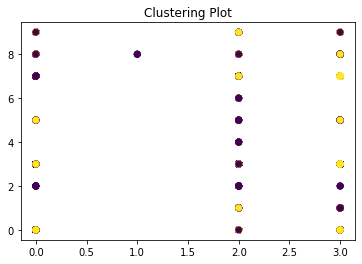

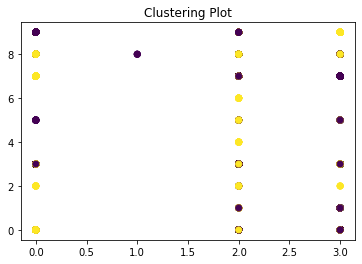

In [ ]:
#Plot features 0 and 1 with their actual labels and their predicted labels
f1=0
f2=1
plot_2dclustering(X,new_y,f1,f2)
plot_2dclustering(X,y,f1,f2)

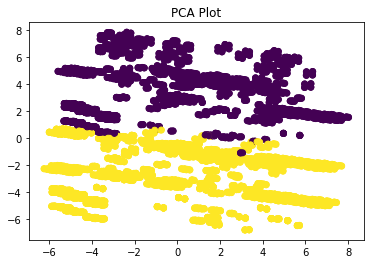

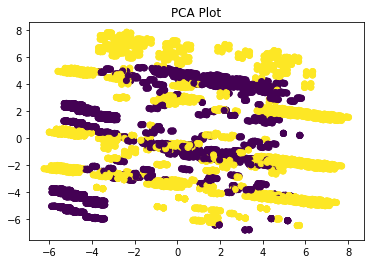

In [ ]:
#Plot the first two principle components with their actual labels and their predicted labels
plot_2dclustering_PCA(X,new_y)
plot_2dclustering_PCA(X,y)

In [ ]:
import numpy as np

class Kmedoids:

    def __init__(self, k):
        self.k = k
        self.medoids = []

    def fit(self, x, imax):
        [n, d] = np.shape(x)  # [#samples, #dimensions]
        k = self.k


        # Calculate pairwise Euclidean distance
        dist = np.zeros((n,n))
        for i in range(n):
          dist[i,:] = np.sqrt(np.sum(np.power(x[i,:] - x,2), axis=1))

        c = np.zeros(n) # Cluster assignment
        # Randomly pick k samples as
        # clusters center
        a = np.arange(n)
        np.random.shuffle(a)
        a = np.sort(a[0:k]) # Clusters center
        a_t = np.copy(a)    # Copy of cluster centers

        for i in range(imax):
          # Calculate cluster assignment 
          c = np.argmin(dist[:,a], axis=1)
          # Update cluster assignment
          for j in range(k):
              aa = np.arange(n)
              idx = aa[c == j] # Current cluster
              
              idxx = np.argmin(np.mean(dist[np.ix_(idx,idx)],axis=1))
              a_t[j] = idx[idxx]
              np.sort(a_t)
              if np.array_equal(a, a_t):
                break
              a = np.copy(a_t)
        self.medoids = a
        #print(self.medoids)

    def predict(self, x):
        [n, d] = np.shape(x) 
        k = self.k

        medoids = self.medoids

        dist = np.zeros((n,k))
        for i in range(n):
          dist[i,:] = np.sqrt(np.sum(np.power(x[i,:] - x[medoids],2), axis=1))
        return np.argmin(dist, axis=1)

In [ ]:

### Call Kmedoids
###set iteration as 50
###run clustering on the dataset
###run prediction on the data and call the predicted labels as new_y


model = Kmedoids(k=2)
iteration=50
model.fit(X,iteration)
#new_y is predicted labels
new_y=model.predict(X)

print(y)
print(new_y)



[0 0 1 ... 1 0 0]
[0 1 1 ... 0 0 0]


In [ ]:
print('Overall purity: {} %'.format(Purity(y,new_y)*100))

Overall purity: 63.11348781937017 %


In [ ]:
new_y=list(new_y)
for i in range(len(new_y)):
  if new_y[i]==0:
    new_y[i]=1
  else:
    new_y[i]=0
new_y=np.asarray(new_y)

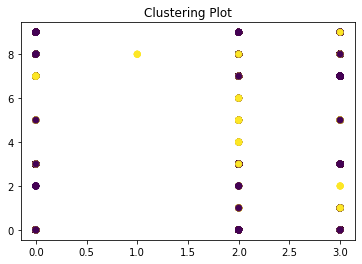

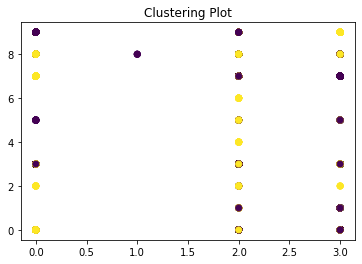

In [ ]:
#Plot two random features with their actual labels and after clsutering with no labels
f1=0
f2=1
plot_2dclustering(X,new_y,f1,f2)
plot_2dclustering(X,y,f1,f2)

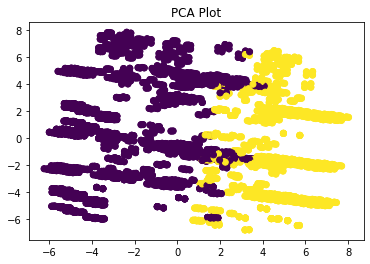

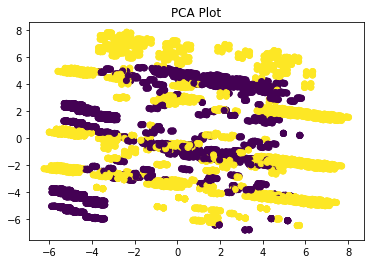

In [ ]:
#Plot the first two principle components with their actual labels and after clsutering with no labels
plot_2dclustering_PCA(X,new_y)
plot_2dclustering_PCA(X,y)